### Subagents: (Supervisor Model)

Note:
* Documentation now recommend using the supervisor pattern directly via tools rather than this create_supervisor from langgraph_supervisor for most use cases.

In [1]:
##### Supervisor using in-built function

from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_tavily import TavilySearch

d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\RAGs In Depth\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
d:\RAGs In Depth\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


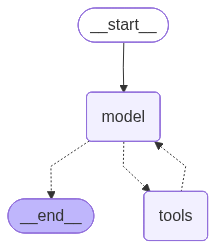

In [2]:
# custom tools for math agent

@tool
def add(a:int, b:int)->int:
    'this function takes two integers and return sum of them'
    return a+b

@tool
def sub(a:int, b:int)->int:
    'this function takes two integers and returns its subtraction result'
    return a-b


math_agent=create_agent(
    model=init_chat_model(model="groq:llama-3.1-8b-instant"),
    tools=[add, sub],
    name="math agent"
)

math_agent

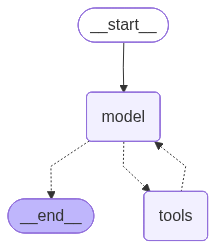

In [3]:
#web search agent

tools = [TavilySearch(max_results=2)]

web_search_agent = create_agent(
    model=init_chat_model(model="groq:llama-3.1-8b-instant"),
                        tools=tools,
                        name="web search agent")

web_search_agent

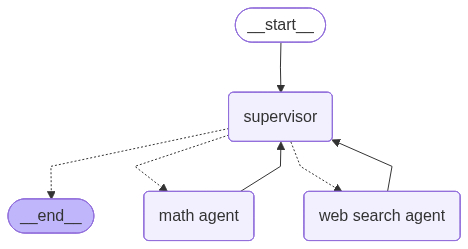

In [4]:
#creating supervisor node

base_model= init_chat_model(model="groq:llama-3.1-8b-instant")

# specifying names of agents is mandatory, else you get value error

supervisor = create_supervisor(
    agents=[math_agent, web_search_agent],
    model=base_model,
    add_handoff_back_messages=True,
    output_mode="full_history"  #you can also use "last_messages" option
).compile()

supervisor

In [5]:
user_question="what is latest news about ai agents, what is result of 5 sums 3"
supervisor.invoke({"messages":{"role":"user", "content": user_question }})

{'messages': [HumanMessage(content='what is latest news about ai agents, what is result of 5 sums 3', additional_kwargs={}, response_metadata={}, id='dbb364d4-4dd9-4862-bd90-222c79f540f9'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='supervisor', id='0fb9c935-db9e-4361-8312-344182714b26', tool_calls=[{'name': 'transfer_to_web_search_agent', 'args': {}, 'id': 'geqa0b4ay', 'type': 'tool_call'}]),
  ToolMessage(content='Successfully transferred to web search agent', name='transfer_to_web_search_agent', id='a253b571-5e6e-47d6-b22e-be1f8c1a802c', tool_call_id='geqa0b4ay'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cy0dq64r7', 'function': {'arguments': '{"query":"latest news about ai agents","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 1688, 'total_tokens': 1728, 'completion_time': 0.048270784,